**Building and Evaluating Using XGBoost and Hyperparameter Tuning with Weights and Biases Sweeps.**

This notebook is intended for utilizing the preprocessing steps from the preceding notebook to construct a model using XGBoost, a high-performance gradient boosting framework. 

In addition, this notebook incorporates the utilization of weights and biases sweeps, which is a process that enables the tuning of hyperparameters to enhance the performance of the model.

The parameters of the best-performing run are employed to train the final model. Subsequently, the model is evaluated on a previously unseen test set to assess its ability to generalize well beyond the training data.

NOTE: The notebook is run on Google Colab T4 GPU

**1. Import Required Libraries**

In [5]:
# python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn libraries
from sklearn.base import clone
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import cross_validate, TimeSeriesSplit

# other libraries
import joblib
import wandb
import xgboost as xgb
import yellowbrick.model_selection as ms

**2. Common Steps**

These steps have been used in previous notebooks and are being implemented here in a similar fashion to facilitate comparability and consistency in our analysis.

In [6]:
train_df = pd.read_csv(r"E:\NYC Taxi Trip Duration Prediction\data\training_datasets\train.csv") # load train.csv
print(f'Shape (Training): {train_df.shape}') # verify train.csv row/column count

test_df = pd.read_csv(r"E:\NYC Taxi Trip Duration Prediction\data\training_datasets\test.csv") # load test.csv
print(f'Shape (Testing): {test_df.shape}') # verify test.csv row/column count

Shape (Training): (1216082, 20)
Shape (Testing): (226667, 20)


In [7]:
# order train_df and test_df according to timestamps
train_df = train_df.sort_values(by='pickup_datetime', ascending=True)
test_df = test_df.sort_values(by='pickup_datetime', ascending=True)

In [8]:
# convert columns mentioned in 6th point to categorical in both train and test sets
train_df = train_df.astype({
    'vendor_id': 'category', 
    'passenger_count': 'category',
    'store_and_fwd_flag': 'category',
    '2AMto7AM_7AMto2AM': 'category',
    'holiday': 'category'
})

test_df = test_df.astype({
    'vendor_id': 'category', 
    'passenger_count': 'category',
    'store_and_fwd_flag': 'category',
    '2AMto7AM_7AMto2AM': 'category',
    'holiday': 'category'
})

In [9]:
# split training data set: features and target
X_train = train_df[train_df.columns.difference(['id', 'pickup_datetime', 'trip_duration'])]
y_train = train_df["trip_duration"] # target
print(f'Train Shape: {X_train.shape}, {y_train.shape}')

# split testing data set: features and target
X_test = test_df[test_df.columns.difference(['id', 'pickup_datetime', 'trip_duration'])]
y_test = test_df["trip_duration"] # target
print(f'Test Shape: {X_test.shape}, {y_test.shape}')

Train Shape: (1216082, 17), (1216082,)
Test Shape: (226667, 17), (226667,)


In [10]:
# TimeSeriesSplits
# keeping gap=0, and, max_train_size and test_size as default
time_series_split_cv = TimeSeriesSplit(
    n_splits=4 # better results with 4 splits compared to 5
)

In [11]:
# define dictionary of scores used in cross_val_score
scoring = {
    "root_mean_squared_log_error": make_scorer(
        lambda y_true, y_pred: -mean_squared_log_error(y_true, y_pred, squared=False)
    ),
}

# evaluation function
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        return_estimator=True,
        return_train_score=True
    )
    rmsle = -cv_results["test_root_mean_squared_log_error"]
    print(
        f"Root Mean Squared Log Error: {rmsle.mean():.3f} +/- {rmsle.std():.3f}\n"
    )
    return cv_results

**3. Modelling on Initial Run** 

An initial run is performed on all available features to establish a baseline performance (for XGBoost on all the available features) level for the model, using a XGBoost Regressor.

In [ ]:
# define XGBRegressor model
xgb_model = xgb.XGBRegressor(
    objective='reg:squaredlogerror',
    tree_method="gpu_hist", enable_categorical=True,
    random_state=56
)
# transform the target
model = TransformedTargetRegressor(regressor=xgb_model, func=np.log1p, inverse_func=np.expm1)

In [ ]:
# cross validation results
cv_results = evaluate(clone(model), X_train, y_train, cv=time_series_split_cv)
print('test_root_mean_squared_log_error', cv_results['test_root_mean_squared_log_error'])
print('train_root_mean_squared_log_error', cv_results['train_root_mean_squared_log_error'])

Root Mean Squared Log Error: 0.404 +/- 0.006

test_root_mean_squared_log_error [-0.40117503 -0.39870568 -0.40233185 -0.41311837]
train_root_mean_squared_log_error [-0.3735647  -0.37877591 -0.38140243 -0.38470794]


**4. Feature Selection**

A process was used to select the features for the model. Specifically, a systematic approach was followed that involved analyzing the importance scores and correlations of each feature, as well as considering the potential impact of removing certain features on model performance.

Firstly, importance scores were analyzed for all features using a XGBoost Regressor trained on all available features. Features were analyzed based on gain, weight, and cover. Features with low importance scores across all types (viz. *`minute`* and *`store_fwb_flag`*) were deemed not significant for the prediction task.

Next, correlations between pairs of features were analyzed, and highly correlated features were identified. In such cases, only one of the highly correlated features was retained to avoid multicollinearity issues (viz. *`hour`*).

After applying the feature selection process, a reduced set of features consisting of (n-3) predictors was left, which was used to train the final model. This feature reduction led to an improvement in the model's generalization performance, as shown by a slight decrease in deviation score and RMSLE. This suggests that the removed features were not significantly contributing to the model's predictive power.

It is important to note that this feature selection process may have some limitations. For instance, there may be some features that are important for certain subgroups within the data but were not identified as important in the overall analysis. Nevertheless, this approach helped to reduce the dataset's dimensionality while retaining the most important features for the prediction task."


**4.1 Feature Importance Scores**

<center>

|FEATURE |GAIN |COVER |WEIGHT |- |FEATURE |GAIN |COVER |WEIGHT
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|2AMto7AM_7AMto2AM|1.957|4077.448|23.0||month|0.486|2385.547|50.0
|direction|1.372|4078.082|683.0||passenger_count|0.787|3144.139|41.0
|dropoff_latitude|0.744|2700.706|640.0||pickup_latitude|0.365|2519.771|586.0
|dropoff_longitude|0.445|1770.662|554.0||pickup_longitude|0.436|2236.614|492.0
|haversine_distance|21.522 |16514.367|797.0||store_and_fwd_flag|0.308|1010.264|1.0
|holiday|1.119|1892.651|60.0||vendor_id|5.585|2585.102|48.0
|hour|0.712|3774.723|69.0||week|0.375|3916.948|182.0
|minute|0.203|56.507|95.0||weekday|0.841|2083.798|264.0
|minute_of_the_day|1.009|5590.511|725.0||

</center>

In [ ]:
# calculare the feature importance scores
for i, estimator in enumerate(cv_results['estimator']):
    print(f"Fold {i+1}:")
    booster = estimator.regressor_.get_booster()
    importance_scores = booster.get_score(importance_type='weight')
    print(importance_scores)

Fold 1:
{'2AMto7AM_7AMto2AM': 23.0, 'direction': 598.0, 'dropoff_latitude': 514.0, 'dropoff_longitude': 459.0, 'haversine_distance': 791.0, 'holiday': 48.0, 'hour': 69.0, 'minute': 117.0, 'minute_of_the_day': 597.0, 'month': 12.0, 'passenger_count': 38.0, 'pickup_latitude': 445.0, 'pickup_longitude': 470.0, 'store_and_fwd_flag': 1.0, 'vendor_id': 58.0, 'week': 152.0, 'weekday': 235.0}
Fold 2:
{'2AMto7AM_7AMto2AM': 26.0, 'direction': 683.0, 'dropoff_latitude': 615.0, 'dropoff_longitude': 501.0, 'haversine_distance': 795.0, 'holiday': 45.0, 'hour': 72.0, 'minute': 114.0, 'minute_of_the_day': 697.0, 'month': 34.0, 'passenger_count': 28.0, 'pickup_latitude': 528.0, 'pickup_longitude': 474.0, 'store_and_fwd_flag': 2.0, 'vendor_id': 53.0, 'week': 145.0, 'weekday': 265.0}
Fold 3:
{'2AMto7AM_7AMto2AM': 29.0, 'direction': 685.0, 'dropoff_latitude': 666.0, 'dropoff_longitude': 507.0, 'haversine_distance': 786.0, 'holiday': 50.0, 'hour': 64.0, 'minute': 111.0, 'minute_of_the_day': 696.0, 'month':

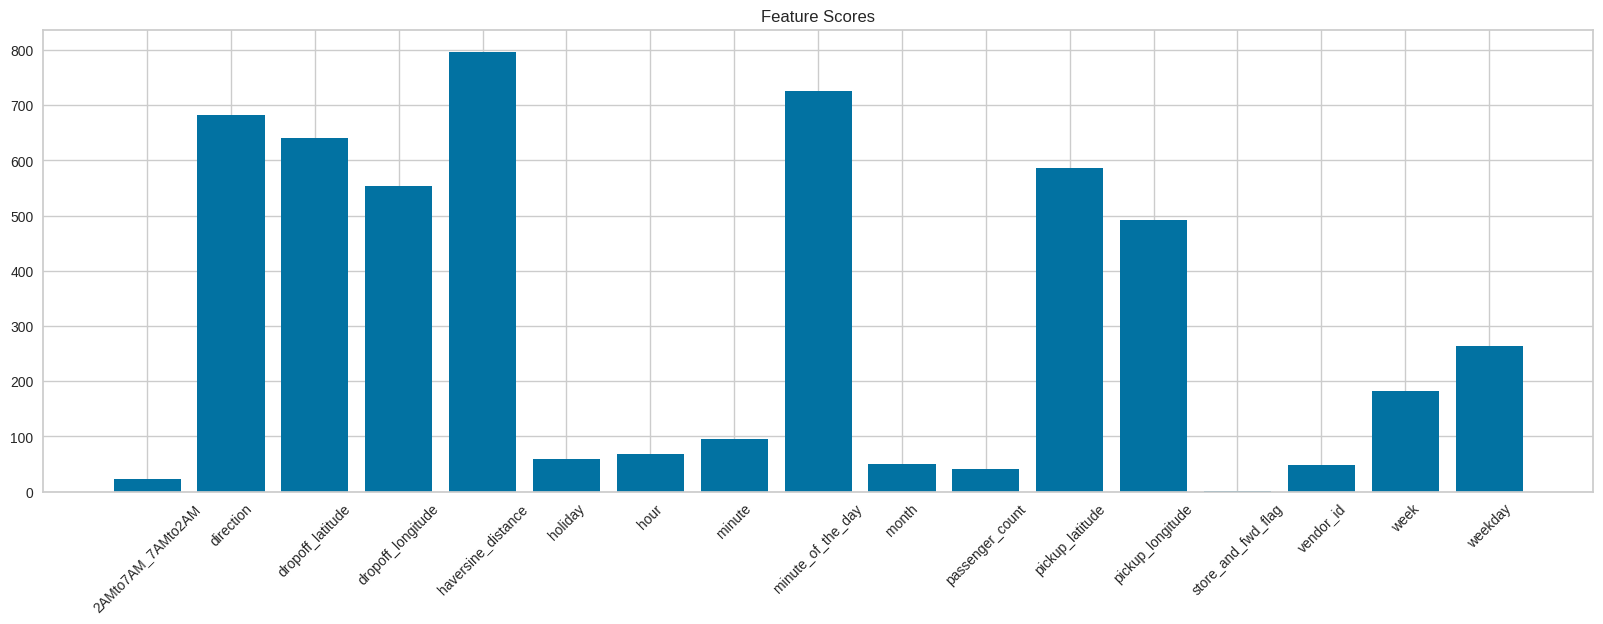

In [ ]:
# plot feature importance scores
plt.figure(figsize=(20, 6))
plt.bar(importance_scores.keys(), importance_scores.values())
plt.title('Feature Scores')
plt.xticks(rotation=45)
plt.show()

**4.2 Plot Correlations**

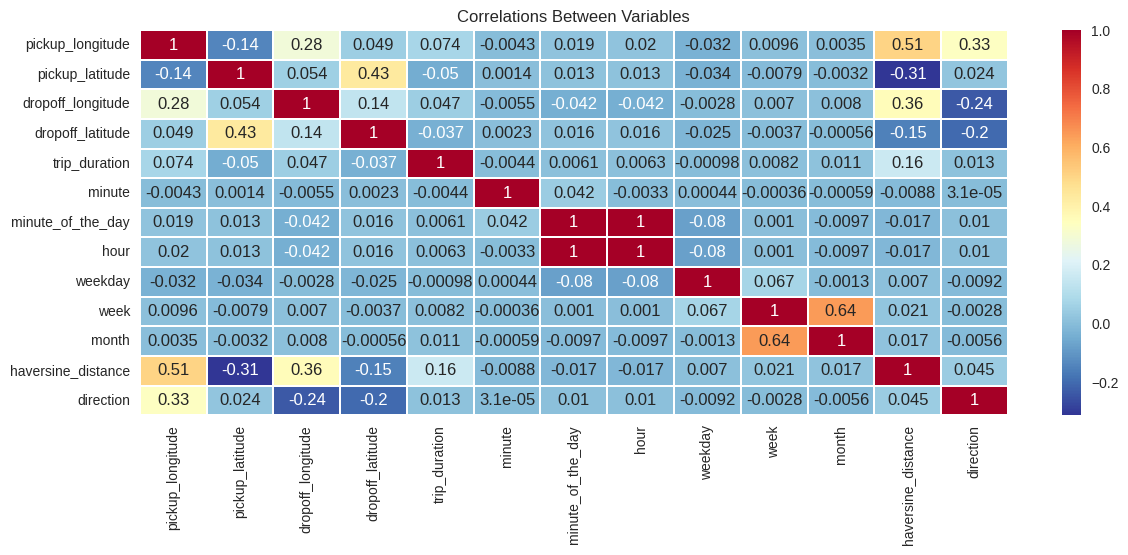

In [ ]:
# plot correlations
fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(data=train_df.corr(), annot=True, cmap = plt.cm.RdYlBu_r, linewidths=.1, ax=ax).set_title('Correlations Between Variables');

Features that are highly correlated:

1.   *`hour`* and *`minute_of_the_day`*

2.   *`month`* and *`week`*

**5. Modelling after Dropping Unimpactful Features**

After analyzing both of the plots, we proceed to test the model by removing a few features.

In [12]:
# remove features that are not contributing to the results
# analyzed results using feature importance, and correlations
X_train = X_train[X_train.columns.difference([
    'hour',
    'minute',
    'store_and_fwd_flag'
])]

print(f'Train Shape: {X_train.shape}, {y_train.shape}')

Train Shape: (1216082, 14), (1216082,)


In [ ]:
# cross validation results
cv_results = evaluate(clone(model), X_train, y_train, cv=time_series_split_cv)
print('test_root_mean_squared_log_error', cv_results['test_root_mean_squared_log_error'])
print('train_root_mean_squared_log_error', cv_results['train_root_mean_squared_log_error'])

Root Mean Squared Log Error: 0.403 +/- 0.005

test_root_mean_squared_log_error [-0.40079044 -0.39865391 -0.4016501  -0.41271559]
train_root_mean_squared_log_error [-0.3743255  -0.37918462 -0.38219447 -0.38443392]


**6. Validation Curves**

This particular section was engaged in plotting scores to assess parameter values utilizing a Python library called Yellowbrick. The purpose of this process was to visually analyze the performance of machine learning models with different hyperparameters and to identify the optimal values for these parameters.

The code cell were executed with varying parameter names and ranges.

The sample code utilized in the current context is presented as follows:

```
vc = ms.ValidationCurve(
    model, 
    param_name='regressor__max_depth', 
    param_range=[1, 2, 3, 4, 5, 7, 9, 12],
    cv=time_series_split_cv,
    scoring=make_scorer(
        lambda y_true, y_pred: -mean_squared_log_error(y_true, y_pred, squared=False)
    )
)

vc.fit(X_train, y_train)
vc.poof()
```

**6. HyperParameter Optimization**

The hyperparameters were optimized by utilizing the weights and biases framework to experiment with different parameter settings and configurations, to arrive at the optimal values for the model.

In [ ]:
# login to wandb 
wandb.login()

In [ ]:
# define train model
def train(config=None):
  
  # initialize a new wandb run
  with wandb.init(project="nyc-taxi-trip-duration", job_type="hyperparameter-optimization", config=config):
    
    # define XGBRegressor
    xgb_model = xgb.XGBRegressor(
      # fixed hyperparameters
      objective='reg:squaredlogerror',
      tree_method='gpu_hist',
      enable_categorical=True,
      random_state=56,
      # variable hyperparameters
      max_depth=wandb.config.max_depth,
      learning_rate=wandb.config.learning_rate,
      n_estimators=wandb.config.n_estimators,
      min_child_weight=wandb.config.min_child_weight,
      subsample=wandb.config.subsample,
      colsample_bytree=wandb.config.colsample_bytree,
      gamma=wandb.config.gamma,
      reg_alpha=wandb.config.reg_alpha,
      reg_lambda=wandb.config.reg_lambda
    )
    
    # tranform target
    model = TransformedTargetRegressor(regressor=xgb_model, func=np.log1p, inverse_func=np.expm1)
    
    # cross validation results
    cv_results = evaluate(clone(model), X_train, y_train, cv=time_series_split_cv)
    
    # log mean RMSLE for train and test sets
    wandb.log({
        'mean_test_rmsle': -np.mean(cv_results['test_root_mean_squared_log_error']), 
        'mean_train_rmsle': -np.mean(cv_results['train_root_mean_squared_log_error'])
    })

**6.1 Coarse-Grained Search**

To perform a coarse-grained hyperparameter search, we employed a randomized search approach.

Access the results of the sweep at Weights&Biases platform by following this [link](https://wandb.ai/bhavsar-kaustubh/nyc-taxi-trip-duration/sweeps/k2hg9lq9?workspace=user-bhavsar-kaustubh).

Best Score (Find it's associated parameters in WandB):

> Mean Train RMSLE: 0.354 | Mean Test RMSLE: 0.392

In [ ]:
# define sweep configs
sweep_configs = {
  "method": "random",
  "metric": {"name": "mean_test_rmsle", "goal": "minimize"},
  "parameters": {
    "max_depth": {"values": [1, 2, 3, 4, 5, 6, 7, 8, 10, 12]},
    "learning_rate": {"distribution": "uniform", "min": 0.05, "max": 0.3},
    "n_estimators": {"values": [500, 700, 800, 1000]},
    "min_child_weight": {"values": [1, 2, 3, 4, 5, 6, 7, 8]},
    "subsample": {"values": [0.6, 0.7, 0.8, 0.9, 1.0]},
    "colsample_bytree": {"values": [0.6, 0.7, 0.8, 0.9, 1.0]},
    "gamma": {"values": [0.001, 0.01, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]},
    "reg_alpha": {"distribution": "uniform", "min": 0, "max": 1},
    "reg_lambda": {"distribution": "uniform", "min": 0.01, "max": 1}
  },
}

# initialize sweep
sweep_id = wandb.sweep(sweep_configs, project="nyc-taxi-trip-duration")
# run sweep agent
wandb.agent(sweep_id=sweep_id, function=train, count=1000)

**6.2 Fine-Grained Search**

Following the coarse hyperparameter search, we conducted a more targeted and focused search around the optimal hyperparameters obtained from the previous step, using the Bayesian optimization technique to fine-tune and refine the model's hyperparameters.

Access the results of the sweep at Weights&Biases platform by following this [link](https://wandb.ai/bhavsar-kaustubh/nyc-taxi-trip-duration/sweeps/kdyj5p74?workspace=user-bhavsar-kaustubh).

Best Score (Find it's associated parameters in WandB):

> Mean Train RMSLE: 0.355 | Mean Test RMSLE: 0.393

Scores are almost similar to the top performer from coarse-grained search.

In [ ]:
sweep_configs = {
    "method": "bayes",
    "metric": {
        "name": "mean_test_rmsle",
        "goal": "minimize"
    },
    "parameters": {
        "colsample_bytree": {"distribution": "uniform", "min": 0.5, "max": 0.7},
        "gamma": {"distribution": "log_uniform", "min": -6, "max": 0},
        "learning_rate": {"distribution": "uniform", "min": 0.1, "max": 0.2},
        "max_depth": {"distribution": "int_uniform", "min": 10, "max": 15},
        "min_child_weight": {"distribution": "int_uniform", "min": 6, "max": 10},
        "n_estimators": {"distribution": "int_uniform", "min": 700, "max": 1200},
        "reg_alpha": {"distribution": "uniform", "min": 0.5, "max": 1},
        "reg_lambda": {"distribution": "uniform", "min": 0.6, "max": 0.8},
        "subsample": {"distribution": "uniform", "min": 0.8, "max": 1}
    },
    "early_terminate": {
        "type": "hyperband",
        "s": 2,
        "eta": 3,
        "max_iter": 20
    }
}

# initialize sweep
sweep_id = wandb.sweep(sweep_configs, project="nyc-taxi-trip-duration")
# run sweep agent
wandb.agent(sweep_id=sweep_id, function=train)

**7. Final Model Training**

The best hyperparameters discovered during the fine-grained hyperparameter search were used to train the final model on the entire available training data. After training, the model is tested on the separate test dataset to assess its generalization performance and evaluate its effectiveness in making accurate predictions on new, unseen data.

To make it clear:

*   Cross-validation was done on only training dataset from Jan to May.

*   For training of final model based on parameters from top performing candidate in fine-grained search:

    * Training Set: Records from Jan to May

    * Testing Set: Records from June

Final Scores:

> Train RMSLE: 0.351 | Test RMSLE: 0.439

In [ ]:
# login WandB
api = wandb.Api()

In [14]:
# get best sweep run
sweep = api.sweep("bhavsar-kaustubh/nyc-taxi-trip-duration/kdyj5p74")
runs = sorted(
    sweep.runs,
    key=lambda run: run.summary.get("mean_test_rmsle", 0), 
    reverse=False
)

In [15]:
# remove features from test set that were originally removed from train set
X_test = X_test[X_test.columns.difference([
    'hour',
    'minute',
    'store_and_fwd_flag'
])]

print(f'Test Shape: {X_test.shape}, {y_test.shape}')

Test Shape: (226667, 14), (226667,)


In [16]:
def train_final_model(X_train, y_train, X_test, y_test):
    
  # initialize W&B run
  with wandb.init(project="nyc-taxi-trip-duration", job_type='final-model-training') as run:
    # set config parameters
    config = wandb.config
    config.objective='reg:squaredlogerror'
    config.tree_method='gpu_hist'
    config.enable_categorical=True
    config.random_state=56
    config.update(runs[0].config) # updating best hyperparameters from fine-grained search
        
    # train XGBoostRegressor model
    xgb_model = xgb.XGBRegressor(
        objective=config.objective,
        tree_method=config.tree_method,
        enable_categorical=config.enable_categorical,
        random_state=config.random_state,
        max_depth=config.max_depth,
        learning_rate=config.learning_rate,
        n_estimators=config.n_estimators,
        min_child_weight=config.min_child_weight,
        subsample=config.subsample,
        colsample_bytree=config.colsample_bytree,
        gamma=config.gamma,
        reg_alpha=config.reg_alpha,
        reg_lambda=config.reg_lambda
    )
    # tranform target
    model = TransformedTargetRegressor(regressor=xgb_model, func=np.log1p, inverse_func=np.expm1)

    # call to fit
    model.fit(X_train, y_train)
        
    # evaluate model
    y_test_pred = model.predict(X_test) # on test set
    test_rmsle = np.sqrt(mean_squared_log_error(y_test, y_test_pred))
    y_train_pred = model.predict(X_train) # on train set
    train_rmsle = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
        
    # log RMSLE for train and test sets
    wandb.log({
        'TestRMSLE': test_rmsle, 
        'TrainRMSLE': train_rmsle
    })
        
    # save model as artifact to W&B
    model_artifact = wandb.Artifact(
        "XGBoostRegressor", 
        type="model", 
        description="The final model that is trained on an XGBoost Regressor on the entire training dataset and evaluating its performance on the test set.",
        metadata=dict(config)
    )
    joblib.dump(model, "final_xgb_model.bin") # dump model in binary format
    model_artifact.add_file("final_xgb_model.bin")
    wandb.run.log_artifact(model_artifact) # log model as artifact

train_final_model(X_train, y_train, X_test, y_test)

wandb: Currently logged in as: bhavsar-kaustubh. Use `wandb login --relogin` to force relogin


TestRMSLE,▁
TrainRMSLE,▁
TestRMSLE,0.43918
TrainRMSLE,0.35113
